In [2]:
import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

import matplotlib.gridspec as gridspec
import datetime as dt
mpl.rcParams['figure.facecolor'] = 'white'
import time

from palettable.cartocolors.qualitative import Prism_8
prism = Prism_8.mpl_colors
import xarray as xr
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = '#303039'

from palettable.cmocean.sequential import Tempo_20
tempo = mcolors.ListedColormap(Tempo_20.mpl_colors)
from palettable.cmocean.diverging import Balance_20
bal = Balance_20.mpl_colormap
from palettable.cmocean.diverging import Curl_20

curltop =  mcolors.ListedColormap(Curl_20.mpl_colors[10:])
curlbot =  mcolors.ListedColormap(Curl_20.mpl_colors[:10])
import sys
from palettable.cmocean.sequential import Deep_20
deep = mcolors.ListedColormap(Deep_20.mpl_colors)

from palettable.cmocean.diverging import Balance_20
bal = Balance_20.mpl_colormap

from palettable.cartocolors.diverging import Geyser_7
curl = Geyser_7.mpl_colormap

bal.set_bad('white')

#from shared_functions import get_var
from run_params import *

FileNotFoundError: [Errno 2] No such file or directory: '/camp2e/gleung/aerograd/grad//a-A-2019-09-16-000000-head.txt'

In [ ]:
style = '/home/gleung/scripts/styles/bee-paperlight.mplstyle'
plt.style.use(style)

import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ['/home/gleung/scripts/futura']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Futura'
rcParams["figure.facecolor"] = 'white'
rcParams['figure.dpi'] = 100  

In [ ]:
dataPath = f"/camp2e/gleung/aerograd"

run = 'grad-open'
ccn = 'CCCMP'

dx = 200

anaPath = f"/camp2e/gleung/aerograd-analysis/"
figPath = f"/camp2e/gleung/aerograd-figures/"

if not os.path.isdir(figPath):
    os.mkdir(figPath)

# Sounding

In [24]:
ds = xr.open_dataset(f"{dataPath}/{run}/a-A-2019-09-16-160000-g1.h5")[['DN0']]#),engine='h5netcdf')[['THETA','PI','RV','UC','VC','DN0']]
ds = ds.rename_dims({'phony_dim_2':'z', 'phony_dim_1':'y', 'phony_dim_0':'x'})

In [25]:
ds = ds.sel(x=500,y=500)

In [26]:
df = ds.to_dataframe()

In [28]:
import metpy.calc as mcalc
from metpy.plots import SkewT
from metpy.units import units   

/home/gleung/miniconda3/envs/aerograd/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [27]:
cp = 1004
p00 = 100000
rgas = 287

In [126]:
df['ps'] = p00*(df['PI']/cp)**(cp/rgas) #pressure in Pa
df['ts'] = df['THETA']*df['PI']/cp #temperature in Kelvin
df['es'] = 610.78*np.exp(17.269*(df['ts']-273.15)/(df['ts']-35.86))#saturation mixing pressure

#dwpt calc
df['ws'] = 0.622*df['es']/(df['ps']-df['es'])
df['rs'] = df[['RV','ws']].min(axis=1) #find minimum between RV and ws
df['esln'] =np.log(df['ps']*(df['rs']+1E-8)/(df['rs']+1E-8 + 0.622))
df['td'] = ((35.86*df['esln'])-4947.2325)/(df['esln']-23.6837)

df['ps'] = df['ps']* 0.01 #convert pressure to hPa/mbarSkewT

In [32]:
dn0 = df.DN0

In [ ]:
print(alt[62])
print(df['ps'].loc[62])

In [ ]:
'''fig = plt.figure(figsize=(9,9))
skew = SkewT(fig, rotation=45)
'''
p = df.ps.values * units.hPa
u = df.UC.values * units.meters/units.seconds
v = df.VC.values * units.meters/units.seconds
T = df.ts.values * units.kelvin
Td = df.td.values * units.kelvin

'''skew.plot_dry_adiabats(alpha=0.5, color='gray', lw=1)
skew.plot_moist_adiabats(alpha=0.5, color='black',lw=1)
skew.plot_mixing_lines(alpha=0.5, lw=1)

skew.plot(p, T)
skew.plot(p, Td, ls='--')
skew.plot_barbs(p[:len(u)][::5],u[::5],v[::5],color='black')

ax.set_xlabel('$^\circ$C')
ax.set_ylabel('hPa')

plt.savefig(f"{figPath}{run}-skewt.png",dpi=300,bbox_inches='tight')'''

In [ ]:
rh = mcalc.relative_humidity_from_dewpoint(T,Td)

# Full Crosssection

In [ ]:
surf = pd.read_csv(f"{anaPath}{run}/mean-surf.csv",index_col=0)

surf.index = surf.index*100/1000

In [ ]:
print(os.listdir(f"{anaPath}{run}/mean_cross_section/"))

In [ ]:
wc = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/WC.csv")
uc = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/UC.csv")

winds = pd.DataFrame(wc.stack(),columns=['WC'])
winds['UC'] = uc.stack()
winds = winds.reset_index()
winds.columns = ['z','x','WC','UC']

winds['x'] = winds.x*100/1000
winds['alt'] = winds.z.map(alt/1000)

winds['xbin'] = round(resx*round(winds.x/resx), 2)
winds['altbin'] = round(resz*round(winds.alt/resz), 4)

winds = winds.groupby(['xbin','altbin']).mean().reset_index()

In [ ]:
variables = ['SWDN','LWDN','SWDN',
             ccn,'WC','TCON']
cmaps = [curltop,curltop,bal,
         tempo,bal,deep]
levels = [np.linspace(425,650,11), np.linspace(0,400,11), sorted(np.append(np.linspace(-4E-5,0,11), np.linspace(0,4E-5,11)[1:])),
       np.logspace(-9,-7,11), np.linspace(-0.015,0.015,11), np.logspace(-6,-4,11)]

labels = ['W m$^{-2}$','W m$^{-2}$','K s$^{-1}$',
          'kg kg$^{-1}$','m s$^{-1}$','kg kg$^{-1}$']

fig = plt.figure(figsize=(8,9), constrained_layout=False, tight_layout=False)

spec = gridspec.GridSpec(ncols=2, nrows=7, figure=fig)
ax1 = fig.add_subplot(spec[0:2, 0])
ax2 = fig.add_subplot(spec[0:2, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(spec[2:4, 0], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(spec[2:4, 1], sharex=ax1, sharey=ax1)
ax5 = fig.add_subplot(spec[4:6, 0], sharex=ax1, sharey=ax1)
ax6 = fig.add_subplot(spec[4:6, 1], sharex=ax1, sharey=ax1)
ax7 = fig.add_subplot(spec[6, 0], sharex=ax1)
ax8 = fig.add_subplot(spec[6, 1], sharex=ax1)

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

fig.subplots_adjust(wspace=0.375,hspace=0.55)

for ax, var, cmap, lev, lab in zip(axes, variables, cmaps, levels, labels):
    plot = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/{var}.csv")
    plot.index = alt[1:-1]/1000
    plot.columns = plot.columns*100/1000
    #plot = df.pivot(index='altbin',columns='xbin',values=var)
    
    if (var == ccn) or (var=='TCON'):
        n = mcolors.LogNorm()
        plot = plot[plot>0]
        fmt = mticker.LogFormatterMathtext()
    elif var=='WC':
        n = mcolors.TwoSlopeNorm(vcenter=0)
        fmt = mticker.ScalarFormatter(useMathText=True)
        fmt.set_powerlimits((-2,2))
    else:
        n = None
        fmt = mticker.ScalarFormatter(useMathText=True)

    c = ax.contourf(plot.columns, plot.index, plot.values,
                   cmap = cmap,
                   extend='both',
                   norm = n,
                   levels = lev)

    #ax.quiver(winds.x,winds.alt, winds.UC, winds.WC*5)
    
    ax.xaxis.set_visible(False)
    
    cax = fig.add_axes([ax.get_position().x1 + 0.01, 
                       ax.get_position().y0,
                       0.025,
                       ax.get_position().y1 - ax.get_position().y0])
    plt.colorbar(c,cax=cax, label=lab)
    

ax7.plot(surf.index,surf.SFLUX_T * cp, color=red)
ax7b = ax7.twinx()
ax7b.plot(surf.index,surf.SFLUX_R * lv, color=blue)

ax7.set_ylabel('Sensible (W m$^{{-2}}$)')
ax7b.set_ylabel('Latent (W m$^{{-2}}$)')

ax7.yaxis.label.set_color(red)
ax7.tick_params(axis='y', colors=red)
ax7b.yaxis.label.set_color(blue)
ax7b.tick_params(axis='y', colors=blue)

ax8.plot(surf.index,surf.AODT, color='black')


for ax in [ax1,ax3,ax5]:
    ax.set_ylabel('Altitude (km)')
    ax.axvline(25)
    ax.axvline(75)
    
for ax in [ax2,ax4,ax6]:
    ax.yaxis.set_visible(False)
    ax.axvline(25)
    ax.axvline(75)
    
for ax in [ax7,ax8]:
    ax.set_xlabel('x (km)')
    ax.axvline(25)
    ax.axvline(75)
    
ax.set_xlim(0,100)
    
ax1.set_title('(a) Downwelling Shortwave')
ax2.set_title('(b) Downwelling Longwave')
ax3.set_title('(c) Radiative Heating Rate')
ax4.set_title('(d) Aerosol Mass Mixing Ratio')
ax5.set_title('(e) Vertical Velocity')
ax6.set_title('(f) Total Condensate')
ax7.set_title('(g) Surface Fluxes')
ax8.set_title('(h) AOD')

plt.savefig(f"{figPath}{run}-cross-all-alltimes.png",dpi=300, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/camp2e/gleung/aerograd-analysis/emit.diurn/mean_cross_section/SWDN.csv'

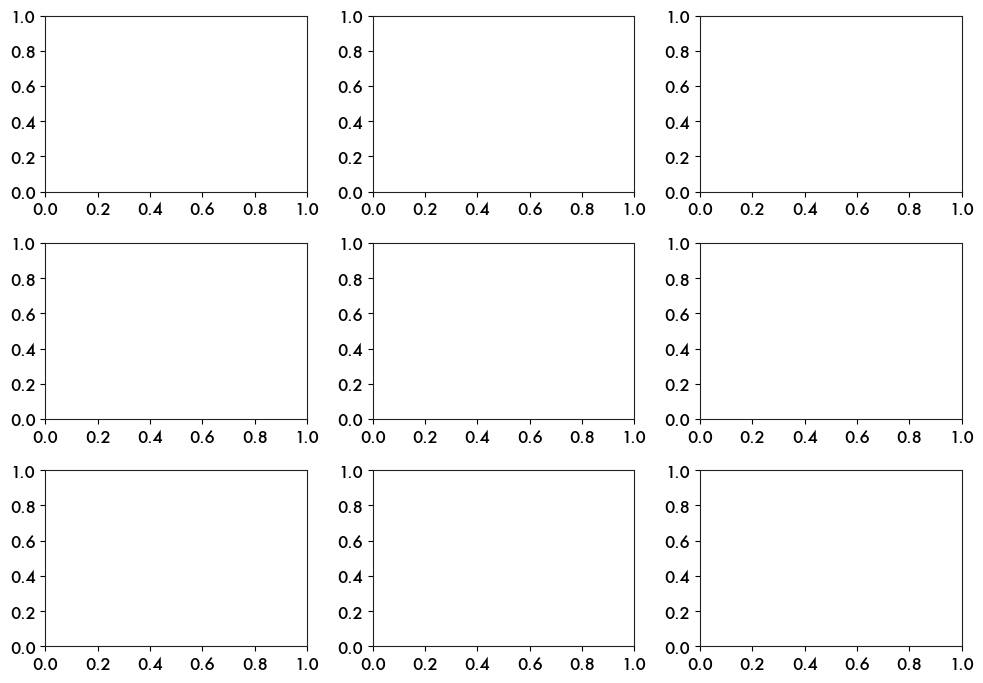

In [5]:
variables = ['SWDN','LWDN','SWDN+LWDN','SWUP','LWUP','SWUP+LWUP','SWHR','LWHR','FTHRD']
fig, axes = plt.subplots(3,3)

for ax, var in zip(axes.flatten(), variables):
    if '+' in var:
        plot = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/{var.split('+')[0]}.csv")+pd.read_pickle(f"{anaPath}{run}/mean_cross_section/{var.split('+')[1]}.csv")
        cmap = curltop
        n = None
        
        plot.index = alt[1:-1]/1000
        plot.columns = plot.columns*100/1000
    elif var == 'SWHR':
        up = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/SWUP.csv")
        dn = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/SWDN.csv")
        
        plot = dn - dn.shift(1) + up.shift(1) - up
        plot = (plot.T/(df.DN0 * df.PI * (alt - alt.shift(1))).iloc[1:-1]).T * 3600 * 24
        plot = plot.iloc[:-1]
        plot.index = alt[1:-1]/1000
        plot.columns = plot.columns*100/1000
        cmap = curl
        n = mcolors.TwoSlopeNorm(vcenter=0)
    elif var == 'LWHR':
        up = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/LWUP.csv")
        dn = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/LWDN.csv")
        
        plot = dn - dn.shift(1) + up.shift(1) - up
        plot = (plot.T/(df.DN0 * df.PI * (alt - alt.shift(1))).iloc[1:-1]).T * 3600 * 24
        plot = plot.iloc[:-1]
        plot.index = alt[1:-1]/1000
        plot.columns = plot.columns*100/1000
        cmap = curl
        n = mcolors.TwoSlopeNorm(vcenter=0)
    elif var == 'FTHRD':
        plot = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/{var}.csv") * 3600 * 24
        cmap = curl
        n = mcolors.TwoSlopeNorm(vcenter=0)
        
        plot.index = alt[1:-1]/1000
        plot.columns = plot.columns*100/1000
    
    else:
    
        plot = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/{var}.csv")
        cmap = curltop
        n = None
        
        plot.index = alt[1:-1]/1000
        plot.columns = plot.columns*100/1000
    
    plot = plot.iloc[1:]
    
    c = ax.contourf(plot.columns, plot.index, plot.values,
                   cmap = cmap,
                   extend='both',
                    norm = n,
                   levels = 10)
    
    plt.colorbar(c, ax=ax)
    
    
    ax.set_title(var)
    
#plt.savefig(f"{figPath}{run}-cross-all.png",dpi=300, bbox_inches='tight')

In [ ]:
print(alt.shift(1))

In [ ]:
plot = dn - dn.shift(1) + up.shift(1) - up
plot = (plot.T/(p.magnitude * dn0 * 100 * cp).iloc[1:-1]).T * 3600 * 24

In [ ]:
print(plot)

In [ ]:
print(plot)

In [ ]:
print()

In [ ]:
fig = plt.figure(figsize=(10,5), constrained_layout=False, tight_layout=False)
fig.subplots_adjust(wspace=0.1)

spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
ax1 = fig.add_subplot(spec[0:2,0:2])
ax2 = fig.add_subplot(spec[0:2,2],sharey=ax1)
ax3 = fig.add_subplot(spec[3,0:2],sharex=ax1)
ax4 = fig.add_subplot(spec[2,0:2],sharex=ax1)
ax5 = fig.add_subplot(spec[0:2,3],sharey=ax1)

plot = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/FTHRD.csv") * 24 * 60 * 60
plot.index = alt[1:-1]/1000
plot.columns = plot.columns*100/1000

c = ax1.contourf(plot.columns, plot.index, plot.values,
                levels = sorted(np.append(np.linspace(-3,0,16), np.linspace(0,1,5)[1:])),
                 cmap=bal,
                norm = mcolors.TwoSlopeNorm(vcenter=0))

ax1.quiver(winds.y,winds.alt, winds.UC, winds.WC*10, scale=3)

cax = fig.add_axes([ax1.get_position().x0- 0.08,ax1.get_position().y0,0.03,ax1.get_position().y1-ax1.get_position().y0])
plt.colorbar(c, cax=cax, label = 'Radiative Heating Rate (K/day)')
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')
'''ax2.plot(df.ts[1:-1], alt[1:-1]/1000)
ax2.plot(df.td[1:-1], alt[1:-1]/1000)
'''
#ax3.plot(surf.index,surf.AODT, color='black')

plot = pd.DataFrame(pd.read_pickle(f"{anaPath}{run}/mean_cross_section/{ccn}.csv").loc[0])
plot.columns = [ccn]
plot.index = plot.index*100/1000
plot['grad'] = (((plot[ccn].shift(-1)-plot[ccn].shift(1))/(plot.index.to_series().shift(-1) - plot.index.to_series().shift(1))).rolling(3).median())**2

ax3.plot(plot.index,plot[ccn], color='black', label = 'Aero')
ax3b = ax3.twinx()

ax3b.plot(plot.index,plot.grad, color='gray', label = 'Grad(Aero)')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2)

plot = pd.DataFrame(pd.read_pickle(f"{anaPath}{run}/mean_cross_section/FTHRD.csv"))
plot.columns = plot.columns*100/1000

ax4.plot(plot.columns,plot.loc[65:91].mean(), label = '5.5-9km')
#ax4.plot(plot.columns,plot.loc[76:82].mean(), label = '7-8km')
    
'''ax2.plot(plot[[p for p in plot.columns if (p<=0.1) | (p>=0.9)]].mean(axis=1), alt[1:-1]/1000, color=red)    
ax2.plot(plot[[p for p in plot.columns if (p>=0.4) & (p<=0.6)]].mean(axis=1), alt[1:-1]/1000, color=blue)  
ax2.set_xlim(-3.5E-5,0)
'''

ax2.plot(plot[[p for p in plot.columns if (p>=40) & (p<=60)]].mean(axis=1) -
         plot[[p for p in plot.columns if (p<=10) | (p>=90)]].mean(axis=1),
         alt[1:-1]/1000, 
        label = 'Center - Edge')  

ax5.plot(((df.THETA-df.THETA.shift(1))/(alt - alt.shift(1)).rolling(5, center=True).mean())[1:-1],
    alt[1:-1]/1000, label='Theta')

ax5b = ax5.twiny()

ax5b.plot(rh[1:-1], alt[1:-1]/1000, label='RH', color=blue)
ax5.set_xlabel('K/m')

ax5.axvline(0, color=red, ls='--',lw=1)

ax5b.set_xlabel('%')

for ax in [ax1,ax2,ax5]:
    ax.axhline(5.5)
    ax.axhline(9)
    
ax2.axvline(0, ls='--', zorder=0)
ax2.legend()
ax4.legend()

for ax in [ax1,ax4]:
    ax.tick_params(labelbottom=False)
    
for ax in [ax2,ax5]:
    ax.tick_params(labelleft=False)

plt.savefig(f"{figPath}{run}-heatingrates.png",dpi=300, bbox_inches='tight')

In [ ]:
paths = [f"{dataPath}/{run}/{p}" for p in sorted(os.listdir(f"{dataPath}/{run}")) if p.endswith('.h5') & p.startswith('a-A')]

ds = get_var(paths[12*24],['SFLUX_T','SFLUX_R'])
x = ds.mean(dim='x')

In [ ]:
x = 50
dx = 50

for i in range(120):
    print(x, dx)
    x = x+dx
    dx = dx*1.018
    if dx > 300:
        dx = 300

In [ ]:
plot = pd.DataFrame(pd.read_pickle(f"{anaPath}{run}/mean_cross_section/CCCMP.csv"))
plot.columns = plot.columns*100/1000

print(plot.loc[0][0])

print(plot.loc[0][5])

In [ ]:
fig, [ax1,ax2] = plt.subplots(1,2, sharey=True)

plot = pd.DataFrame(pd.read_pickle(f"{anaPath}{run}/mean_cross_section/SWDN.csv"))
plot.columns = plot.columns*100/1000

ax1.plot(plot[[p for p in plot.columns if (p>=0.4) & (p<=0.6)]].mean(axis=1),
        alt[1:-1]/1000)

ax1.plot(plot[[p for p in plot.columns if (p<=0.1) | (p>=0.9)]].mean(axis=1),
        alt[1:-1]/1000)

ax2.plot(100*(plot[[p for p in plot.columns if (p>=0.4) & (p<=0.6)]].mean(axis=1) - 
         plot[[p for p in plot.columns if (p<=0.1) | (p>=0.9)]].mean(axis=1))/
         plot[[p for p in plot.columns if (p<=0.1) | (p>=0.9)]].mean(axis=1),
        alt[1:-1]/1000)

In [ ]:
print(plot.shift(1)**2)

In [ ]:
plt.plot(surf.index, surf.AODT)

# RV total

In [ ]:
run = 'grad-open'

paths = [f"{dataPath}/{run}/{p}" for p in sorted(os.listdir(f"{dataPath}/{run}")) if p.endswith('.h5') & p.startswith('a-L')]

In [ ]:
import h5py 

x = np.zeros(len(paths[::12*1]))

for i, p in enumerate(paths[::12*1]):
    with h5py.File(p) as f:
        l = np.sum(f['RV'][1:119,:,:],axis=(1,2))
        d = np.mean(f['DN0'][1:119,:,:],axis=(1,2))
        print(p)
        x[i] = (l*d*dz).sum()

In [ ]:
plt.plot(np.arange(0,25,1), x)

# Per Timestep Mean

In [ ]:
wc = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/WC.pkl").reset_index()
vc = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/VC.pkl").reset_index()

In [ ]:
w = wc.groupby(['y','z']).mean().reset_index()
v = vc.groupby(['y','z']).mean().reset_index()

In [ ]:
resz = 0.5
resy = 20


winds = w.copy()
winds['VC'] = v.VC
winds['alt'] = winds.z.map(alt/1000)
winds = winds.groupby([resy*round(winds.y//resy), resz*round(winds.alt//resz)]).mean()

In [9]:
tcon = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/TCON.pkl").reset_index()
t = tcon.groupby(['x','z']).mean().reset_index().pivot(index='z',columns='x',values='TCON')

In [10]:
sflux_t = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux/SFLUX_T.pkl").reset_index()
sflux_r = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux/SFLUX_R.pkl").reset_index()
aod = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux/AODT.pkl").reset_index().groupby('x').mean()

shf = sflux_t.groupby('x').mean() * cp
lhf = sflux_r.groupby('x').mean() * lv

/tmp/ipykernel_13570/2857772210.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values,


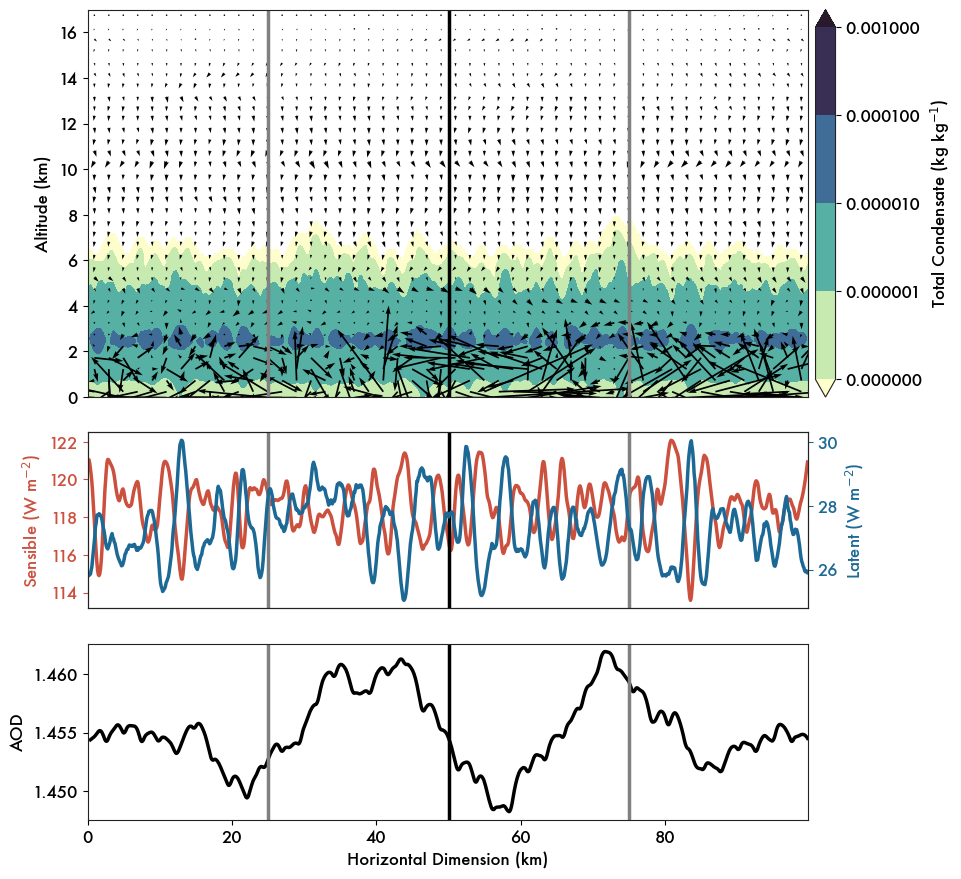

In [11]:
fig = plt.figure(figsize=(8,9), constrained_layout=False, tight_layout=False)

spec = gridspec.GridSpec(ncols=1, nrows=4, figure=fig)
ax1 = fig.add_subplot(spec[0:2, 0])
ax2 = fig.add_subplot(spec[2, 0], sharex=ax1)
ax3 = fig.add_subplot(spec[3, 0], sharex=ax1)

c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values,
                norm = mcolors.LogNorm(),
                levels = np.logspace(-7,-3,5),
                cmap = deep, extend='both')

ax1.quiver(winds.x/10, winds.alt, 
           winds.UC, winds.WC * 5)

ax1.set_ylim(0,17)
ax1.xaxis.set_visible(False)
    
cax = fig.add_axes([ax1.get_position().x1 + 0.01, 
                       ax1.get_position().y0,
                       0.025,
                       ax1.get_position().y1 - ax1.get_position().y0])
plt.colorbar(c,cax=cax, label='Total Condensate (kg kg$^{-1}$)')
    
ax1.set_ylabel('Altitude (km)')

ax2.plot(shf.index/10,shf.SFLUX_T, color=red, label='SHF')
ax2b = ax2.twinx()
ax2b.plot(lhf.index/10,lhf.SFLUX_R, color=blue, label='LHF')

ax2.set_ylabel('Sensible (W m$^{{-2}}$)')
ax2b.set_ylabel('Latent (W m$^{{-2}}$)')

ax2.yaxis.label.set_color(red)
ax2.tick_params(axis='y', colors=red)
ax2b.yaxis.label.set_color(blue)
ax2b.tick_params(axis='y', colors=blue)


ax2.xaxis.set_visible(False)

ax3.plot(aod.index/10,aod.AODT.rolling(5).mean(), color='black')
ax3.set_ylabel('AOD')

for ax in [ax1,ax2,ax3]:
    ax.axvline(50, color='black')
    ax.axvline(25, color='gray')
    ax.axvline(75, color='gray')
    
ax3.set_xlabel('Horizontal Dimension (km)')
plt.savefig(f"{figPath}{run}/tcon.png",dpi=300)

plt.show()

In [12]:
rcp = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/RCP.pkl").reset_index()
rsp = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/RSP.pkl").reset_index()
rpp = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/RPP.pkl").reset_index()

tcon = rcp[['time','z','x']].copy()
tcon['TCON'] = rcp.RCP + rsp.RSP + rpp.RPP

t = tcon.groupby(['x','z']).mean().reset_index().pivot(index='z',columns='x',values='TCON')

/tmp/ipykernel_13570/1909000059.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values,


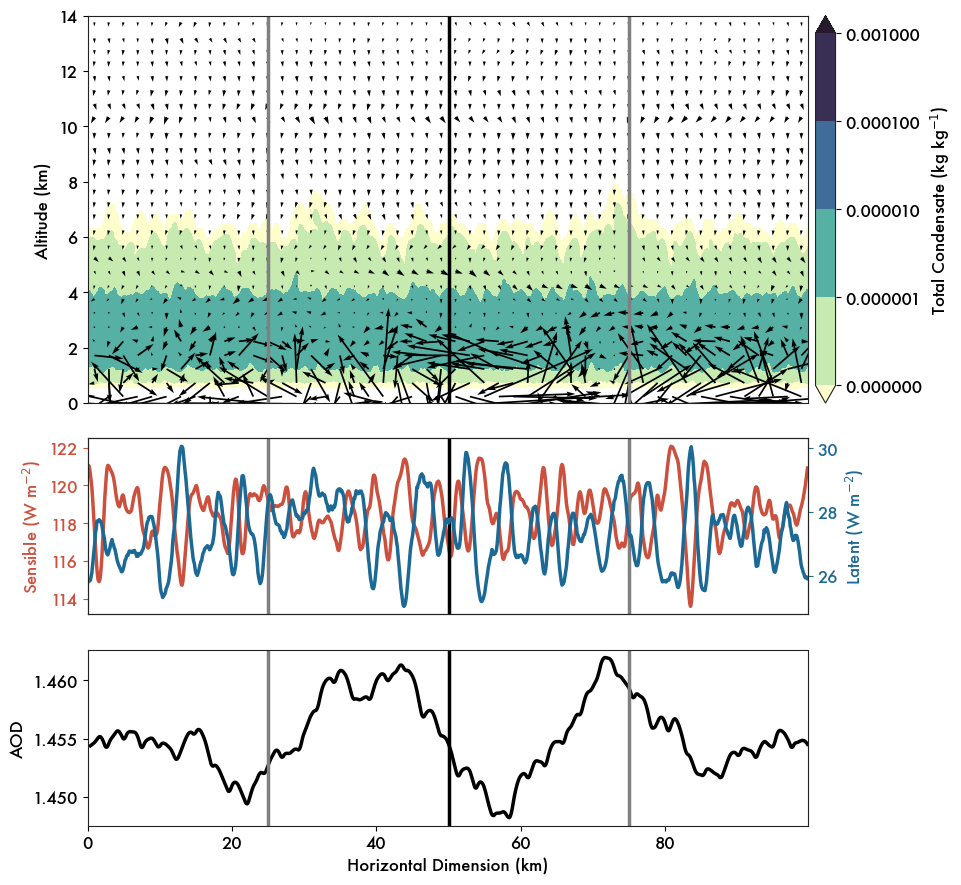

In [13]:
fig = plt.figure(figsize=(8,9), constrained_layout=False, tight_layout=False)

spec = gridspec.GridSpec(ncols=1, nrows=4, figure=fig)
ax1 = fig.add_subplot(spec[0:2, 0])
ax2 = fig.add_subplot(spec[2, 0], sharex=ax1)
ax3 = fig.add_subplot(spec[3, 0], sharex=ax1)

c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values,
                norm = mcolors.LogNorm(),
                levels = np.logspace(-7,-3,5),
                cmap = deep, extend='both')

ax1.quiver(winds.x/10, winds.alt, 
           winds.UC, winds.WC * 5)

ax1.set_ylim(0,14)
ax1.xaxis.set_visible(False)
    
cax = fig.add_axes([ax1.get_position().x1 + 0.01, 
                       ax1.get_position().y0,
                       0.025,
                       ax1.get_position().y1 - ax1.get_position().y0])
plt.colorbar(c,cax=cax, label='Total Condensate (kg kg$^{-1}$)')
    
ax1.set_ylabel('Altitude (km)')

ax2.plot(shf.index/10,shf.SFLUX_T, color=red, label='SHF')
ax2b = ax2.twinx()
ax2b.plot(lhf.index/10,lhf.SFLUX_R, color=blue, label='LHF')

ax2.set_ylabel('Sensible (W m$^{{-2}}$)')
ax2b.set_ylabel('Latent (W m$^{{-2}}$)')

ax2.yaxis.label.set_color(red)
ax2.tick_params(axis='y', colors=red)
ax2b.yaxis.label.set_color(blue)
ax2b.tick_params(axis='y', colors=blue)


ax2.xaxis.set_visible(False)

ax3.plot(aod.index/10,aod.AODT.rolling(5).mean(), color='black')
ax3.set_ylabel('AOD')

for ax in [ax1,ax2,ax3]:
    ax.axvline(50, color='black')
    ax.axvline(25, color='gray')
    ax.axvline(75, color='gray')
    
ax3.set_xlabel('Horizontal Dimension (km)')
plt.savefig(f"{figPath}{run}/tcon_norain.png",dpi=300)

plt.show()

In [14]:
sflux_t = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux/SFLUX_T.pkl").reset_index()
sflux_r = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux/SFLUX_R.pkl").reset_index()
aod = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux/AODT.pkl").reset_index()

In [15]:
fthrd = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/FTHRD.pkl").reset_index()
print(fthrd)

          time    z    x     FTHRD
0            0    0    0  0.000000
1            0    0    1  0.000000
2            0    0    2  0.000000
3            0    0    3  0.000000
4            0    0    4  0.000000
...        ...  ...  ...       ...
34033791   288  117  993 -0.000002
34033792   288  117  994 -0.000002
34033793   288  117  995 -0.000002
34033794   288  117  996 -0.000002
34033795   288  117  997 -0.000002

[34033796 rows x 4 columns]


In [16]:
fthrd.FTHRD = fthrd.FTHRD * 60 * 60 *24

/tmp/ipykernel_13570/969400555.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,


0 36


/tmp/ipykernel_13570/969400555.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,


36 72


/tmp/ipykernel_13570/969400555.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,


72 108


/tmp/ipykernel_13570/969400555.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,


108 144


/tmp/ipykernel_13570/969400555.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,


144 180


/tmp/ipykernel_13570/969400555.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,


180 216


/tmp/ipykernel_13570/969400555.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,


216 252


/tmp/ipykernel_13570/969400555.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,


252 288


/tmp/ipykernel_13570/969400555.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,
/home/gleung/miniconda3/envs/aerograd/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


288 324


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (0, 0)

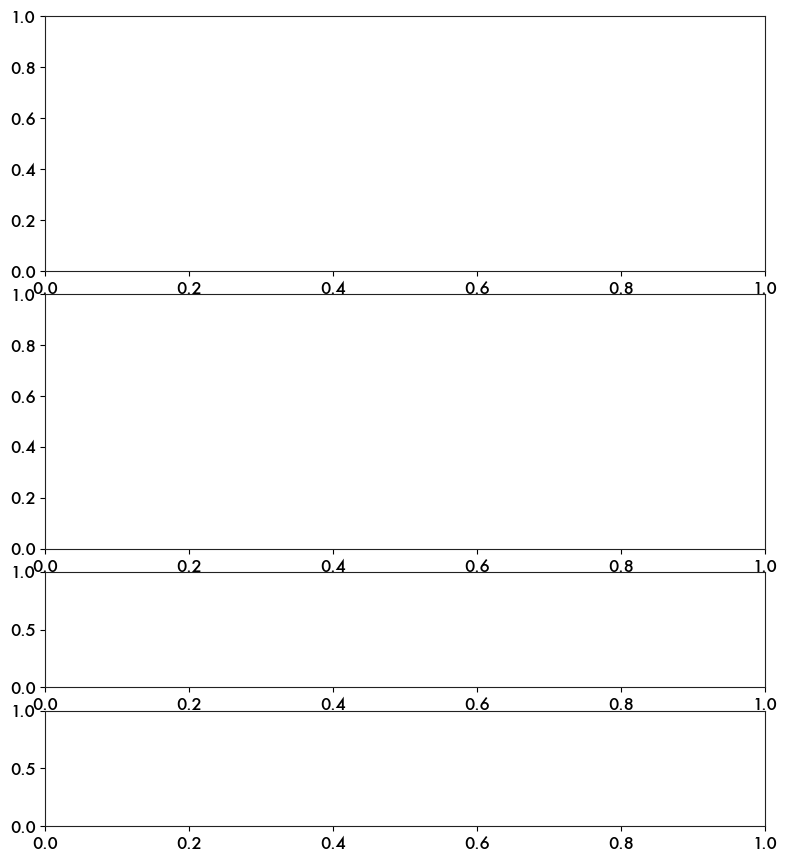

In [17]:
for h in np.arange(0, 12, 1):
    t1 = (h*3*12)
    t2 = (h*3*12) + 3*12
    
    tconsub = tcon[(tcon.time>=t1) & (tcon.time<t2)]
    wsub = wc[(wc.time>=t1) & (wc.time<t2)]
    usub = uc[(uc.time>=t1) & (uc.time<t2)]
    fthrdsub = fthrd[(fthrd.time>=t1) & (fthrd.time<t2)]
    
    t = tconsub.groupby(['x','z']).mean().reset_index()
    w = wsub.groupby(['x','z']).mean().reset_index()
    u = usub.groupby(['x','z']).mean().reset_index()
    f = fthrdsub.groupby(['x','z']).mean().reset_index()
    
    winds = wsub.copy()
    winds['UC'] = usub.UC
    winds['alt'] = winds.z.map(alt/1000)
    winds = winds.groupby([resx*round(winds.x//resx), resz*round(winds.alt//resz)]).mean()
    
    t = t.pivot(index='z',columns='x',values='TCON')
    f = f.pivot(index='z',columns='x',values='FTHRD')
    
    surf = sflux_t.copy()
    surf.SFLUX_T = surf.SFLUX_T * cp
    surf['SFLUX_R'] = sflux_r.SFLUX_R * lv
    surf['AOD'] = aod.AODT
    
    surf = surf[(surf.time>=t1) & (surf.time<t2)]
    surf = surf.groupby('x').mean()
    
    fig = plt.figure(figsize=(8,9), constrained_layout=False, tight_layout=False)

    spec = gridspec.GridSpec(ncols=1, nrows=6, figure=fig)
    ax1 = fig.add_subplot(spec[0:2, 0])
    ax2 = fig.add_subplot(spec[2:4, 0])
    ax3 = fig.add_subplot(spec[4, 0], sharex=ax1)
    ax4 = fig.add_subplot(spec[5, 0], sharex=ax1)

    c = ax1.contourf(t.columns/10, alt[1:-1]/1000, t.values * 1000,
                    norm = mcolors.LogNorm(),
                    levels = np.logspace(-4,0,5),
                    cmap = deep, extend='both')


    cax = fig.add_axes([ax1.get_position().x1 + 0.01, 
                           ax1.get_position().y0,
                           0.025,
                           ax1.get_position().y1 - ax1.get_position().y0])
    plt.colorbar(c,cax=cax, label='Total Condensate (g kg$^{-1}$)')
    
    c = ax2.contourf(f.columns/10, alt[1:-1]/1000, f.values,
                    norm = mcolors.TwoSlopeNorm(vcenter=0),
                     levels = [-8, -6, -4, -2, 0, 2, 4, 6, 8],
                    cmap = bal, extend='both')

    cax = fig.add_axes([ax2.get_position().x1 + 0.01, 
                           ax2.get_position().y0,
                           0.025,
                           ax2.get_position().y1 - ax2.get_position().y0])
    
    plt.colorbar(c,cax=cax, label='Radiative Heating Rate (K day$^{-1}$)')

    
    for ax in [ax1,ax2]:
        ax.quiver(winds.x/10, winds.alt, 
               winds.UC, winds.WC * 5,
                 scale = 1,
                 scale_units = 'xy')

        ax.set_ylim(0,19)
        ax.xaxis.set_visible(False)
        ax.set_ylabel('Altitude (km)')
        
    ax3.plot(surf.index/10,surf.SFLUX_T, color=red, label='SHF')
    ax3b = ax3.twinx()
    ax3b.plot(surf.index/10,surf.SFLUX_R, color=blue, label='LHF')

    ax3.set_ylabel('Sensible (W m$^{{-2}}$)')
    ax3b.set_ylabel('Latent (W m$^{{-2}}$)')
    
    ax3.set_ylim(0, 250)
    ax3b.set_ylim(0, 150)

    ax3.yaxis.label.set_color(red)
    ax3.tick_params(axis='y', colors=red)
    ax3b.yaxis.label.set_color(blue)
    ax3b.tick_params(axis='y', colors=blue)

    ax3.xaxis.set_visible(False)

    ax4.plot(surf.index/10,surf.AOD.rolling(5).mean(), color='black')
    ax4.set_ylabel('AOD')

    for ax in [ax1,ax2,ax3,ax4]:
        ax.axvline(50, color='black')
        ax.axvline(25, color='gray')
        ax.axvline(75, color='gray')

    ax4.set_xlabel('Horizontal Dimension (km)')
    
    plt.suptitle(f"H {int(t1/12)}-{int(t2/12)}")
    plt.savefig(f"{figPath}{run}/tcon_norain_h{str(int(t1/12)).zfill(2)}_h{str(int(t2/12)).zfill(2)}.png",dpi=300,
               bbox_inches='tight')
    
    print(t1, t2)
    plt.close('all')

# Heating Rate Diff

In [ ]:
cln = fthrd[(fthrd.x<=100) | (fthrd.x>=900)]
pol = fthrd[(fthrd.x>=400) & (fthrd.x<=600)]
cln = cln.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='FTHRD')
pol = pol.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='FTHRD')

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1, sharex=True, sharey=True)

c = ax1.contourf(cln.columns/12,alt[1:-1]/1000,cln.values,
            cmap = bal, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            levels = np.linspace(-8, 8, 17),
            extend='both')

plt.colorbar(c, ax=ax1, label = 'K day$^{-1}$')

c = ax2.contourf(cln.columns/12,alt[1:-1]/1000,pol.values,
            cmap = bal, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            levels = np.linspace(-8, 8, 17),
            extend = 'both')

plt.colorbar(c, ax=ax2, label = 'K day$^{-1}$')

c = ax3.contourf(cln.columns/12,alt[1:-1]/1000,pol.values - cln.values,
            cmap = curl, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend='both')

plt.colorbar(c, ax=ax3, label = 'K day$^{-1}$')

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('Altitude (km)')
    
ax1.set_title(f"(a) Low CCN")
ax2.set_title(f"(b) High CCN")
ax3.set_title(f"(c) High - Low CCN")
    
ax3.set_xlabel('Time Elapsed (hrs)')

plt.suptitle('Radiative Heating Rate', fontsize=30)

plt.savefig(f"{figPath}{run}/HeatRates_hov_diff.png",dpi=300)

In [ ]:
cln = tcon[(tcon.x<=100) | (tcon.x>=900)]
pol = tcon[(tcon.x>=400) & (tcon.x<=600)]
cln = cln.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='TCON')
pol = pol.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='TCON')

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1, sharex=True, sharey=True)

c = ax1.contourf(cln.columns/12,alt[1:-1]/1000,cln.values*1000,
            cmap = deep, 
            norm = mcolors.LogNorm(),
            levels = np.logspace(-4, 0, 10),
            extend='both')

plt.colorbar(c, ax=ax1, label = 'g kg$^{-1}$')

c = ax2.contourf(cln.columns/12,alt[1:-1]/1000,pol.values*1000,
            cmap = deep, 
            norm = mcolors.LogNorm(),
            levels = np.logspace(-4, 0, 10),
            extend = 'both')

plt.colorbar(c, ax=ax2, label = 'g kg$^{-1}$')

c = ax3.contourf(cln.columns/12,alt[1:-1]/1000,(pol.values - cln.values) * 1000,
            cmap = curl, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend='both')

plt.colorbar(c, ax=ax3, label = 'g kg$^{-1}$')

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('Altitude (km)')
    
ax1.set_title(f"(a) Low CCN")
ax2.set_title(f"(b) High CCN")
ax3.set_title(f"(c) High - Low CCN")
    

ax3.set_xlabel('Time Elapsed (hrs)')

plt.suptitle('Total Condensate')

plt.savefig(f"{figPath}{run}/TCONnorain_hov_diff.png",dpi=300)

In [ ]:
swdn = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/SWDN.pkl").reset_index()

cln = swdn[(swdn.x<=100) | (swdn.x>=900)]
pol = swdn[(swdn.x>=400) & (swdn.x<=600)]
cln = cln.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='SWDN')
pol = pol.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='SWDN')

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1, sharex=True, sharey=True)

c = ax1.contourf(cln.columns/12,alt[1:-1]/1000,cln.values,
            cmap = curltop, 
            levels = np.linspace(60, 600, 10),
            extend='both')

plt.colorbar(c, ax=ax1, label = 'W m$^{-2}$')

c = ax2.contourf(cln.columns/12,alt[1:-1]/1000,pol.values,
            cmap = curltop, 
            levels = np.linspace(60, 600, 10),
            extend = 'both')

plt.colorbar(c, ax=ax2, label = 'W m$^{-2}$')

c = ax3.contourf(cln.columns/12,alt[1:-1]/1000,pol.values - cln.values,
            cmap = curl, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend='both')

plt.colorbar(c, ax=ax3, label = 'W m$^{-2}$')

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('Altitude (km)')
    
ax1.set_title(f"(a) Low CCN")
ax2.set_title(f"(b) High CCN")
ax3.set_title(f"(c) High - Low CCN")
    
ax3.set_xlabel('Time Elapsed (hrs)')

plt.suptitle('Downwelling Shortwave', fontsize=30)

plt.savefig(f"{figPath}{run}/SWDown_hov_diff.png",dpi=300)

In [ ]:
lwup = (pd.read_pickle(f"{anaPath}{run}/mean_cross_section/LWUP.pkl").LWUP - 
        pd.read_pickle(f"{anaPath}{run}/mean_cross_section/LWDN.pkl").LWDN).reset_index()

lwup.columns = ['time','z','x','LW']

cln = lwup[(lwup.x<=100) | (lwup.x>=900)]
pol = lwup[(lwup.x>=400) & (lwup.x<=600)]

cln = cln.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='LW')
pol = pol.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='LW')

for t in cln.columns:
    cln[t] = (- (1/(cp*dn0))* (cln[t] - cln[t].shift(1)) / ((alt[1:-1]-alt[1:-1].shift(1))).shift(-1)) * 60 * 60 * 24
    pol[t] = (- (1/(cp*dn0))* (pol[t] - pol[t].shift(1)) / ((alt[1:-1]-alt[1:-1].shift(1))).shift(-1)) * 60 * 60 * 24

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1, sharex=True, sharey=True)

c = ax1.contourf(cln.columns/12,alt[1:-1]/1000,cln.values,
            cmap = bal, 
            levels = np.linspace(-9,9,13),
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend='both')

plt.colorbar(c, ax=ax1, label = 'K day$^{-1}$')

c = ax2.contourf(cln.columns/12,alt[1:-1]/1000,pol.values,
            cmap = bal, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            levels = np.linspace(-9,9,13),
            extend = 'both')

plt.colorbar(c, ax=ax2, label = 'K day$^{-1}$')

c = ax3.contourf(cln.columns/12,alt[1:-1]/1000,pol.values - cln.values,
            cmap = curl, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend='both')

plt.colorbar(c, ax=ax3, label = 'K day$^{-1}$')

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('Altitude (km)')
    
ax1.set_title(f"(a) Low CCN")
ax2.set_title(f"(b) High CCN")
ax3.set_title(f"(c) High - Low CCN")
    
ax3.set_xlabel('Time Elapsed (hrs)')

plt.suptitle('Longwave Heating Rate', fontsize=30)

plt.savefig(f"{figPath}sulf.land/LW_HeatRate_diff.png",dpi=300)

In [ ]:
lwup = (pd.read_pickle(f"{anaPath}{run}/mean_cross_section/SWUP.pkl").SWUP - 
        pd.read_pickle(f"{anaPath}{run}/mean_cross_section/SWDN.pkl").SWDN).reset_index()

lwup.columns = ['time','z','x','SW']

cln = lwup[(lwup.x<=100) | (lwup.x>=900)]
pol = lwup[(lwup.x>=400) & (lwup.x<=600)]

cln = cln.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='SW')
pol = pol.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='SW')

for t in cln.columns:
    cln[t] = (- (1/(cp*dn0))* (cln[t] - cln[t].shift(1)) / ((alt[1:-1]-alt[1:-1].shift(1))).shift(-1)) * 60 * 60 * 24
    pol[t] = (- (1/(cp*dn0))* (pol[t] - pol[t].shift(1)) / ((alt[1:-1]-alt[1:-1].shift(1))).shift(-1)) * 60 * 60 * 24

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1, sharex=True, sharey=True)

c = ax1.contourf(cln.columns/12,alt[1:-1]/1000,cln.values,
            cmap = bal, 
            levels = np.linspace(0,9,13),
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend='both')

plt.colorbar(c, ax=ax1, label = 'K day$^{-1}$')

c = ax2.contourf(cln.columns/12,alt[1:-1]/1000,pol.values,
            cmap = bal, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            levels = np.linspace(0,9,13),
            extend = 'both')

plt.colorbar(c, ax=ax2, label = 'K day$^{-1}$')

c = ax3.contourf(cln.columns/12,alt[1:-1]/1000,pol.values - cln.values,
            cmap = curl, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend='both')

plt.colorbar(c, ax=ax3, label = 'K day$^{-1}$')

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('Altitude (km)')
    
ax1.set_title(f"(a) Low CCN")
ax2.set_title(f"(b) High CCN")
ax3.set_title(f"(c) High - Low CCN")
    
ax3.set_xlabel('Time Elapsed (hrs)')

plt.suptitle('Shortwave Heating Rate', fontsize=30)

plt.savefig(f"{figPath}{run}/SW_HeatRate_diff.png",dpi=300)

In [ ]:
cln = wc[(wc.x<=100) | (wc.x>=900)]
pol = wc[(wc.x>=400) & (wc.x<=600)]
cln = cln.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='WC')
pol = pol.groupby(['time','z']).mean().reset_index().pivot(columns='time',index='z',values='WC')

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1, sharex=True, sharey=True)

c = ax1.contourf(cln.columns/12,alt[1:-1]/1000,cln.values,
            cmap = bal, 
            levels = [-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4],
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend='both')

plt.colorbar(c, ax=ax1, label = 'm s$^{-1}$')

c = ax2.contourf(cln.columns/12,alt[1:-1]/1000,pol.values,
            cmap = bal, 
            levels = [-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4],
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend = 'both')

plt.colorbar(c, ax=ax2, label = 'm s$^{-1}$')

c = ax3.contourf(cln.columns/12,alt[1:-1]/1000,pol.values - cln.values,
            cmap = curl, 
            norm = mcolors.TwoSlopeNorm(vcenter=0),
            extend='both')

plt.colorbar(c, ax=ax3, label = 'm s$^{-1}$')

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('Altitude (km)')
    
ax1.set_title(f"(a) Low CCN")
ax2.set_title(f"(b) High CCN")
ax3.set_title(f"(c) High - Low CCN")
    
ax3.set_xlabel('Time Elapsed (hrs)')

plt.suptitle('Vertical Velocity', fontsize=30)

plt.savefig(f"{figPath}{run}/WC_hov_diff.png",dpi=300)

# Surfaces

In [43]:
surf = sflux_t.copy()
surf.SFLUX_T = surf.SFLUX_T * cp
surf['SFLUX_R'] = sflux_r.SFLUX_R * lv
surf['AOD'] = aod.AODT

'''cln = surf[(surf.x<=50) | (surf.x>=950)]
pol = surf[(surf.x>=450) & (surf.x<=550)]

cln = cln.groupby('time').mean()
pol = pol.groupby('time').mean()'''

"cln = surf[(surf.x<=50) | (surf.x>=950)]\npol = surf[(surf.x>=450) & (surf.x<=550)]\n\ncln = cln.groupby('time').mean()\npol = pol.groupby('time').mean()"

In [45]:
lhf = surf.pivot(index='x',columns='time',values='SFLUX_R')
shf = surf.pivot(index='x',columns='time',values='SFLUX_T')

In [20]:
surfu = uc[uc.z<17].groupby(['time','x']).mean()

surfu = surfu.reset_index()

surfu = surfu.pivot(index='x',columns='time',values='UC')

In [29]:
def vertint(df, var):
    
    df['alt'] = (df.z+1).map(alt)
    df['dz'] = (df.z+1).map(alt-alt.shift(1))
    df['DN0'] = (df.z+1).map(dn0)
    
    vint = (df[var] * df.dz* df.DN0).groupby(df.x).sum().copy()
    return(vint)

In [33]:
tcon_vint = pd.DataFrame(columns=[])

for t in tcon.time.unique():
    tcon_vint[t] = vertint(tcon[tcon.time==t], 'TCON')

/tmp/ipykernel_13570/4232757473.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alt'] = (df.z+1).map(alt)
/tmp/ipykernel_13570/4232757473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dz'] = (df.z+1).map(alt-alt.shift(1))
/tmp/ipykernel_13570/4232757473.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [42]:
rswdn = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux/RSHORT.pkl").reset_index()
rlwup = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux/RLONGUP.pkl").reset_index()
rlwdn = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux/RLONG.pkl").reset_index()

rswdn = rswdn.pivot(index='x',columns='time',values='RSHORT')
rlwup = rlwup.pivot(index='x',columns='time',values='RLONGUP')
rlwdn = rlwdn.pivot(index='x',columns='time',values='RLONG')

KeyError: 'y'

/tmp/ipykernel_13570/4110811646.py:21: UserWarning: Log scale: values of z <= 0 have been masked
  c = axes[3].contourf(tcon_vint.columns/12, tcon_vint.index, tcon_vint,


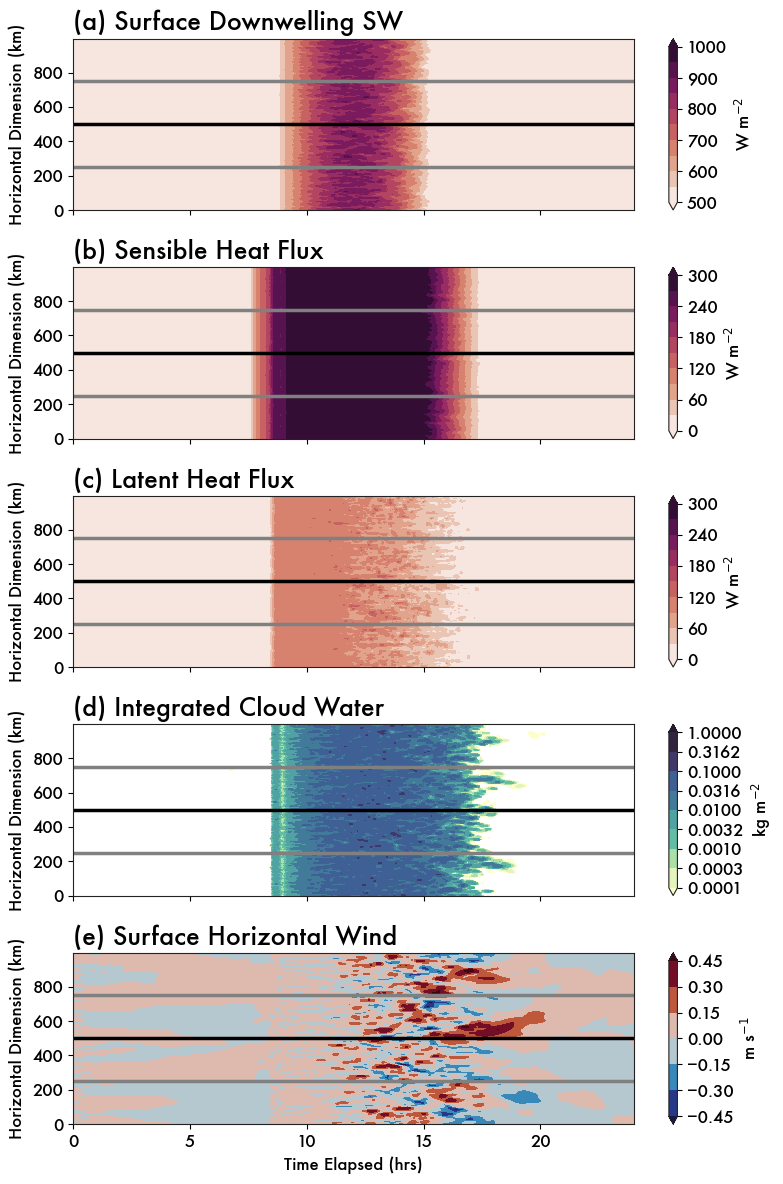

In [41]:
fig, axes = plt.subplots(5,1, sharex=True, sharey=True, figsize=(8,12))

c = axes[0].contourf(shf.columns/12, shf.index, rswdn,
                cmap = curltop,
                levels = np.linspace(500,1000,11),
                extend='both')
plt.colorbar(c, ax=axes[0], label='W m$^{-2}$')

c = axes[1].contourf(shf.columns/12, shf.index, shf,
                cmap = curltop,
                levels = np.linspace(0,300,11),
                extend='both')
plt.colorbar(c, ax=axes[1], label='W m$^{-2}$')

c = axes[2].contourf(shf.columns/12, shf.index, lhf,
                cmap = curltop,
                levels = np.linspace(0,300,11),
                extend = 'both')
plt.colorbar(c, ax=axes[2], label='W m$^{-2}$')

c = axes[3].contourf(tcon_vint.columns/12, tcon_vint.index, tcon_vint,
                cmap = deep,
                levels = np.logspace(-4,0,9),
                extend = 'both',
                norm = mcolors.LogNorm()
                )
plt.colorbar(c, ax=axes[3], label='kg m$^{-2}$')


c = axes[4].contourf(surfu.columns/12, surfu.index, surfu,
                cmap = bal,
                #levels = np.logspace(-4,0,9),
                extend = 'both',
                norm = mcolors.TwoSlopeNorm(vcenter=0)
                )
plt.colorbar(c, ax=axes[4], label='m s$^{-1}$')


'''c = axes[4].contourf(shf.columns/12, shf.index, rlwdn,
                cmap = curltop,
                levels = np.linspace(400,600,11),
                extend = 'both')
plt.colorbar(c, ax=axes[4], label='W m$^{-2}$')

c = axes[5].contourf(tcon_vint.columns/12, tcon_vint.index, rlwup,
                cmap = curltop,
                levels = np.linspace(500,600,11),
                extend = 'both',
                )
plt.colorbar(c, ax=axes[5], label='kg m$^{-2}$')
'''

for ax in axes:
    ax.axhline(1000/2)
    ax.axhline(500/2, color='gray')
    ax.axhline(1500/2, color='gray')
    ax.set_xlim(0,24)
    
    ax.set_ylabel('Horizontal Dimension (km)')
    
axes[-1].set_xlabel('Time Elapsed (hrs)')

axes[0].set_title('(a) Surface Downwelling SW')
axes[1].set_title('(b) Sensible Heat Flux')
axes[2].set_title('(c) Latent Heat Flux')
axes[3].set_title('(d) Integrated Cloud Water')
axes[4].set_title('(e) Surface Horizontal Wind')
#axes[4].set_title('(e) Downwelling LW')
#axes[5].set_title('(f) Upwelling LW')

plt.savefig(f"{figPath}{run}/HeatFlux_hov_horiz-2.png",dpi=300,
           bbox_inches='tight')
plt.show()

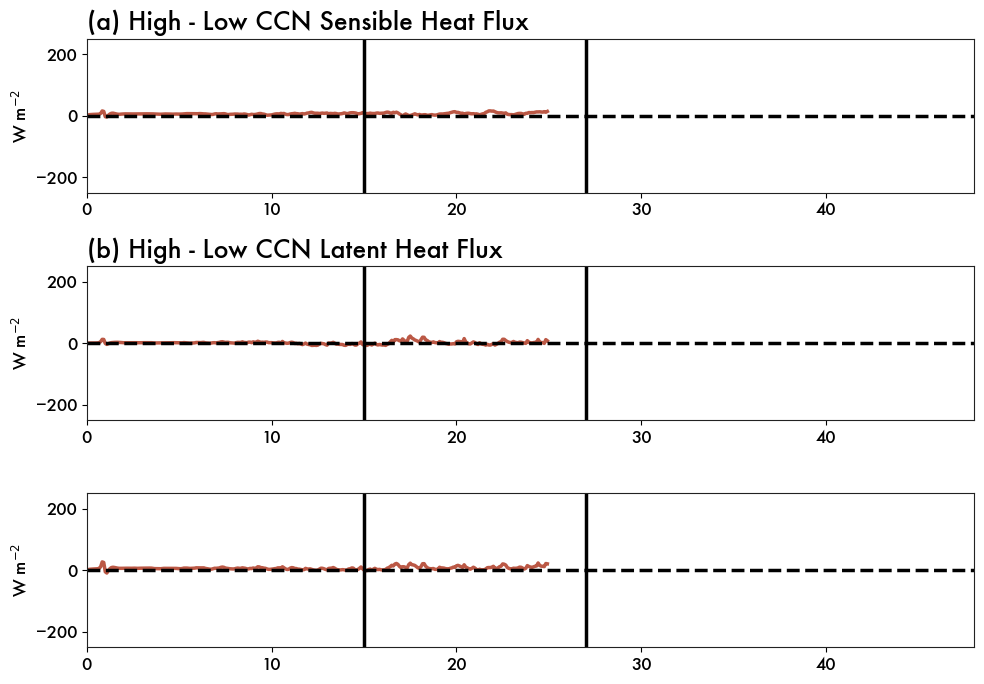

In [38]:
fig, axes = plt.subplots(3,1)

axes[0].plot(pol.index/12,pol.SFLUX_T-cln.SFLUX_T)
axes[1].plot(cln.index/12,pol.SFLUX_R-cln.SFLUX_R)
axes[2].plot(cln.index/12,(pol.SFLUX_R+pol.SFLUX_T)-(cln.SFLUX_R+cln.SFLUX_T))

for ax in axes:
    ax.axhline(0, ls='--')
    
axes[0].set_title(f"(a) High - Low CCN Sensible Heat Flux")
axes[1].set_title(f"(b) High - Low CCN Latent Heat Flux")

for ax in axes:
    ax.set_ylabel('W m$^{-2}$')
    ax.set_ylim(-250,250)
    ax.set_xlim(0,48)
    
    ax.axvline(15)
    ax.axvline(27)

plt.savefig(f"{figPath}{run}/surf_flux_diff.png",dpi=300)

In [38]:
ccn = pd.read_pickle(f"{anaPath}{run}/mean_cross_section/CCCMP.pkl").reset_index()
surfccn = ccn[ccn.z<17].groupby(['time','x']).mean()
surfccn = surfccn.reset_index()
surfccn = surfccn.pivot(index='x',columns='time',values='CCCMP')

In [12]:
print(np.nanmin(surfccn),np.nanmax(surfccn))

2.221391031904532e-09 4.830846018635652e-08


In [ ]:
print(run)

/tmp/ipykernel_13570/1461266337.py:28: UserWarning: Log scale: values of z <= 0 have been masked
  c = axes[1].contourf(tcon_vint.columns/12, tcon_vint.index, tcon_vint,


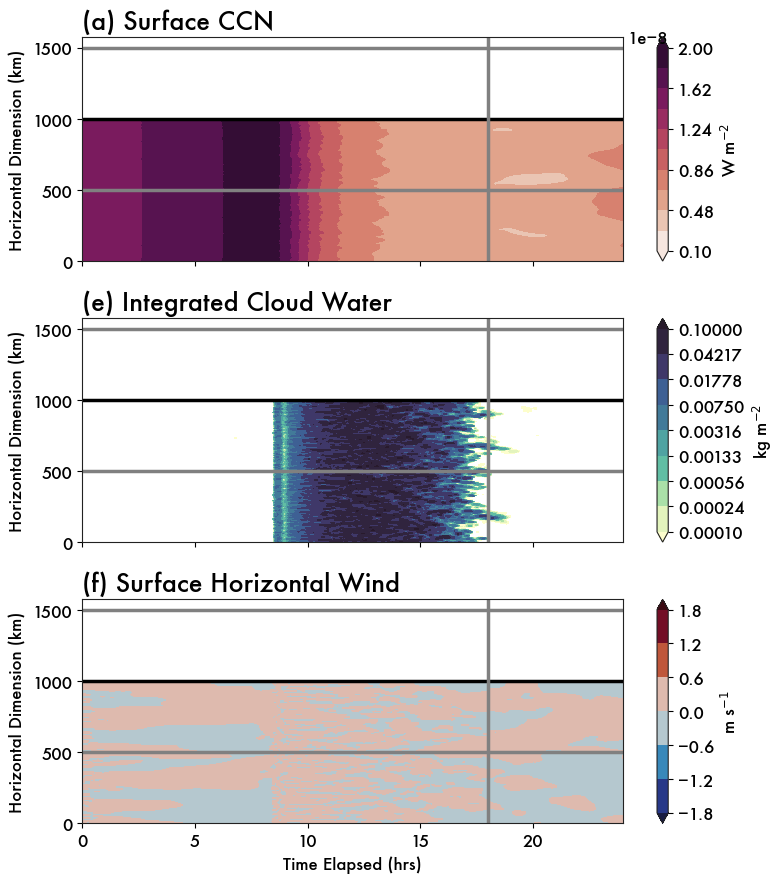

In [39]:
fig, axes = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,9))

c = axes[0].contourf(surfccn.columns/12, surfccn.index, surfccn,
                cmap = curltop,
                levels = np.linspace(1E-9,2E-8,11),
                extend='both')
plt.colorbar(c, ax=axes[0], label='W m$^{-2}$')


'''c = axes[1].contourf(shf.columns/12, shf.index, rswdn,
                cmap = curltop,
                levels = np.linspace(100,550,11),
                extend='both')
plt.colorbar(c, ax=axes[1], label='W m$^{-2}$')

c = axes[2].contourf(shf.columns/12, shf.index, shf,
                cmap = curltop,
                levels = np.linspace(60,300,11),
                extend='both')
plt.colorbar(c, ax=axes[2], label='W m$^{-2}$')

c = axes[3].contourf(shf.columns/12, shf.index, lhf,
                cmap = curltop,
                levels = np.linspace(0,240,11),
                extend = 'both')
plt.colorbar(c, ax=axes[3], label='W m$^{-2}$')
'''
c = axes[1].contourf(tcon_vint.columns/12, tcon_vint.index, tcon_vint,
                cmap = deep,
                levels = np.logspace(-4,-1,9),
                extend = 'both',
                norm = mcolors.LogNorm()
                )
plt.colorbar(c, ax=axes[1], label='kg m$^{-2}$')


c = axes[2].contourf(surfu.columns/12, surfu.index, surfu,
                cmap = bal,
                levels = np.linspace(-1.8,1.8,7),
                extend = 'both',
                norm = mcolors.TwoSlopeNorm(vcenter=0)
                )
plt.colorbar(c, ax=axes[2], label='m s$^{-1}$')


'''c = axes[4].contourf(shf.columns/12, shf.index, rlwdn,
                cmap = curltop,
                levels = np.linspace(400,600,11),
                extend = 'both')
plt.colorbar(c, ax=axes[4], label='W m$^{-2}$')

c = axes[5].contourf(tcon_vint.columns/12, tcon_vint.index, rlwup,
                cmap = curltop,
                levels = np.linspace(500,600,11),
                extend = 'both',
                )
plt.colorbar(c, ax=axes[5], label='kg m$^{-2}$')
'''

for ax in axes:
    ax.axhline(1000)
    ax.axhline(500, color='gray')
    ax.axhline(1500, color='gray')
    ax.set_xlim(0,24)
    ax.axvline(18, color='gray')
    ax.set_ylabel('Horizontal Dimension (km)')
    
axes[-1].set_xlabel('Time Elapsed (hrs)')

axes[0].set_title('(a) Surface CCN')
axes[1].set_title('(e) Integrated Cloud Water')
axes[2].set_title('(f) Surface Horizontal Wind')

plt.savefig(f"{figPath}{run}/HeatFlux_hov_horiz-2.png",dpi=300,
           bbox_inches='tight')
plt.show()

# Winds Mean

In [92]:
print(uc)

          time    z    x        UC
0            0    0    0  0.000000
1            0    0    1  0.000000
2            0    0    2  0.000000
3            0    0    3  0.000000
4            0    0    4  0.000000
...        ...  ...  ...       ...
67949823   576  117  993  0.018307
67949824   576  117  994  0.018177
67949825   576  117  995  0.018049
67949826   576  117  996  0.017922
67949827   576  117  997  0.017796

[67949828 rows x 4 columns]


In [93]:
winds = uc[['time','z','x','UC']].copy()
winds['WC'] = wc.WC

In [94]:
winds.x = winds.x+1

print(winds)

          time    z    x        UC   WC
0            0    0    1  0.000000  0.0
1            0    0    2  0.000000  0.0
2            0    0    3  0.000000  0.0
3            0    0    4  0.000000  0.0
4            0    0    5  0.000000  0.0
...        ...  ...  ...       ...  ...
67949823   576  117  994  0.018307  0.0
67949824   576  117  995  0.018177  0.0
67949825   576  117  996  0.018049  0.0
67949826   576  117  997  0.017922  0.0
67949827   576  117  998  0.017796  0.0

[67949828 rows x 5 columns]


In [95]:
winds['absUC'] = np.nan

In [96]:
winds.loc[winds[winds.x<=500].index,'absUC'] = winds.loc[winds[winds.x<=500],'UC']
winds.loc[winds[winds.x>500].index,'absUC'] = -winds.loc[winds[winds.x>500],'UC']

ValueError: Cannot index with multidimensional key

In [ ]:
winds['absx'] = abs(winds.x-500)

In [ ]:
sub = winds[(winds.time>12*15) & (winds.time<=12*18)]

In [ ]:
sub = sub.groupby(['z','absx']).mean()

In [ ]:
sub = sub.reset_index()

In [ ]:
u = sub.pivot(index='z',columns='absx', values='UC')
w = sub.pivot(index='z',columns='absx', values='WC')

In [ ]:
plt.quiver(u.columns[::15], u.index[::4],
          u.loc[::4,::15], w.loc[::4,::15])